# Importing Libraries

---

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/EVA4/S10
!pip install albumentations


In [0]:
!pip install pytorch-gradcam

In [0]:
!pip install apex

In [0]:
from utils.download_load import download_load
from utils.display_imgs import display_imgs
from utils.tt import train , test, predict, get_misclassified
from utils.disp_summary import disp_summary
from utils.gradcam import grad_cam, gradcam_plot
from utils.lr_finder import LRFinder
from model.ResNet18 import ResNet18

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
#%matplotlib inline
import numpy as np
import torchvision
import torchsummary
from torchsummary import summary
import torch

# Data Loading

---



In [0]:

trainset, testset, train_loader, test_loader, classes = download_load()

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified


#                          Image Albumentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

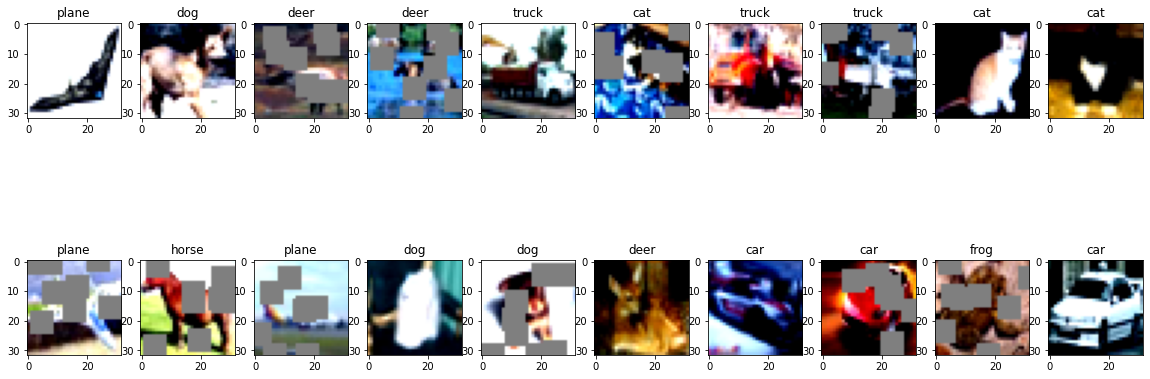

In [0]:
from utils.display_imgs import display_imgs
display_imgs(train_loader, classes)

# Importing ResNet Model and Model Summary

---



In [0]:
use_cuda= torch.cuda.is_available()
device=torch.device('cuda' if use_cuda else 'cpu')
model=ResNet18().to(device)

In [0]:
disp_summary(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         Dropout2d-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
         Dropout2d-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
         Dropout2d-9           [-1, 64, 32, 32]               0
       BasicBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
        Dropout2d-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

/content/gdrive/My Drive/EVA4/S10/model/ResNet18.py:96: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


/content/gdrive/My Drive/EVA4/S10/model/ResNet18.py:96: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


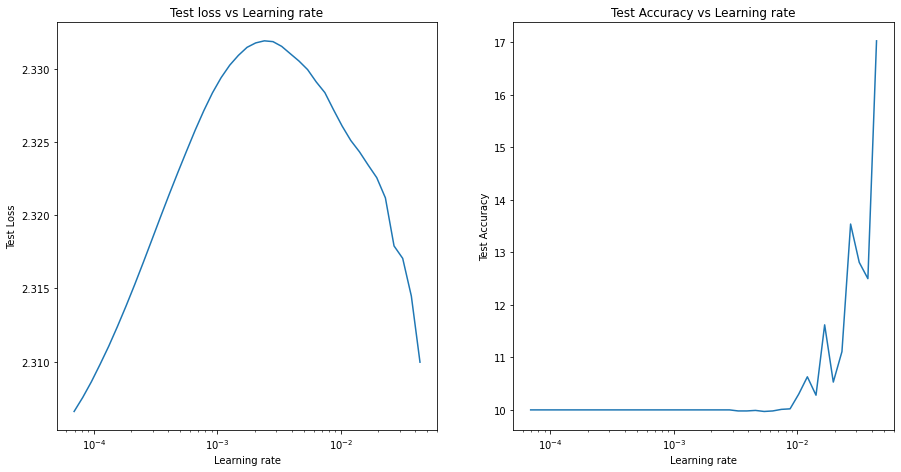

In [0]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
model = ResNet18().to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-5, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader,test_loader, end_lr=100, num_iter=100, step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [0]:
EPOCHS =50
train_accuracy = []
test_accuracy = []
train_loss = []
test_loss = []
from torch.optim.lr_scheduler import ReduceLROnPlateau 
#import CIFAR10 data. Perform Normalize, Batching through transforms.
#train_loader, test_loader, classes = transforms()
criterion = nn.NLLLoss()
# Optimum LR for custom_model = 0.015
optimizer = optim.SGD(model.parameters(), lr=0.04, momentum=0.9, weight_decay=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True, threshold=0.001, cooldown=0, min_lr=1e-4)

for epoch in range(EPOCHS):
  print("epoch:", epoch)
  train_accuracy_delta, train_loss_delta = train(model, device, train_loader, optimizer, criterion, epoch)
  test_accuracy_delta, test_loss_delta = test(model, device, test_loader, criterion)
  scheduler.step(test_loss_delta)
  train_accuracy.append(train_accuracy_delta)
  train_loss.append(train_loss_delta)
  test_accuracy.append(test_accuracy_delta)
  test_loss.append(test_loss_delta)
  
print("Train Accuracy-",train_accuracy)
print("Test Accuracy-",test_accuracy)

print("Train loss-",train_loss)
print("Test loss-",test_loss)



epoch: 0


/content/gdrive/My Drive/EVA4/S10/model/ResNet18.py:96: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


[1,   300] loss: 2.261
[1,   600] loss: 1.850
Epoch Train loss: 1.9874240639267748 Epoch Train Accuracy: 29.022
Epoch Test loss: 1.5767438107994711         Epoch Test Accuracy: 41.32
epoch: 1
[2,   300] loss: 1.665
[2,   600] loss: 1.611
Epoch Train loss: 1.622679856156265 Epoch Train Accuracy: 40.648
Epoch Test loss: 1.3486539641762996         Epoch Test Accuracy: 50.0
epoch: 2
[3,   300] loss: 1.505
[3,   600] loss: 1.492
Epoch Train loss: 1.484954188636262 Epoch Train Accuracy: 46.312
Epoch Test loss: 1.2506266452704267         Epoch Test Accuracy: 54.46
epoch: 3
[4,   300] loss: 1.406
[4,   600] loss: 1.347
Epoch Train loss: 1.3619768050965517 Epoch Train Accuracy: 51.204
Epoch Test loss: 1.0745749503943571         Epoch Test Accuracy: 61.27
epoch: 4
[5,   300] loss: 1.267
[5,   600] loss: 1.229
Epoch Train loss: 1.2437325031442923 Epoch Train Accuracy: 55.368
Epoch Test loss: 1.087234689551554         Epoch Test Accuracy: 61.01
epoch: 5
[6,   300] loss: 1.174
[6,   600] loss: 1.14

In [0]:
def train_test_metrics_graph(train_accuracy, train_loss, test_accuracy, test_loss):
  
  fig, axs = plt.subplots(1,2,figsize=(10,5))
  axs[0].set_title("Accuracy")
  axs[0].plot(train_accuracy, label = "train_accuracy")
  axs[0].plot(test_accuracy, label = "test accuracy")
  axs[0].set_xlabel("Epoch")
  axs[0].set_ylabel("Accuracy")
  axs[0].legend(loc="best")

  axs[1].set_title("Loss")
  axs[1].plot(train_loss, label = "train loss")
  axs[1].plot(test_loss, label = "test loss")
  axs[1].set_xlabel("Epoch")
  axs[1].set_ylabel("Loss")
  axs[1].legend(loc="best")

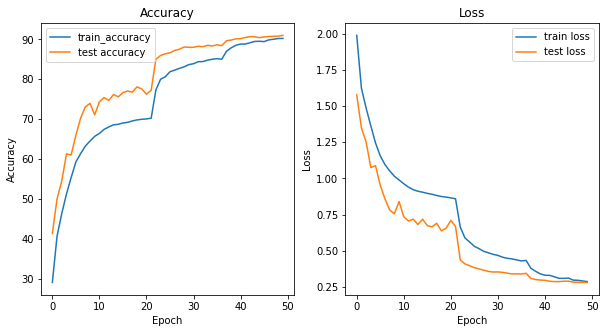

In [0]:
train_test_metrics_graph(train_accuracy, train_loss, test_accuracy, test_loss)

 
 # Image GRADCAM on randomly chosen Misclassified samples


---




/content/gdrive/My Drive/EVA4/S10/model/ResNet18.py:96: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/content/gdrive/My Drive/EVA4/S10/utils/gradcam.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots(1,2)


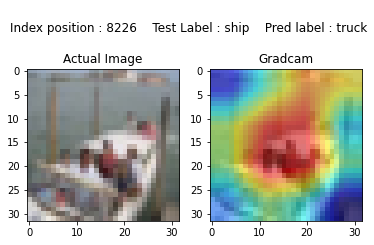

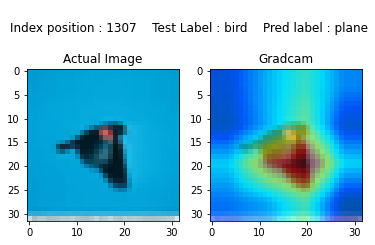

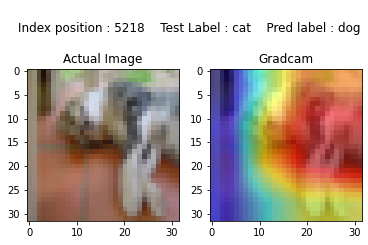

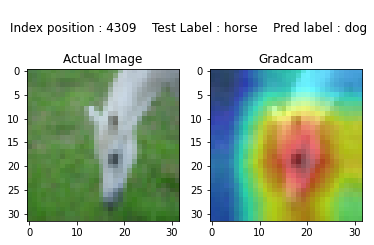

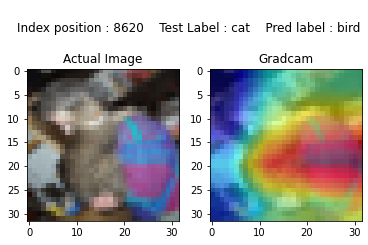

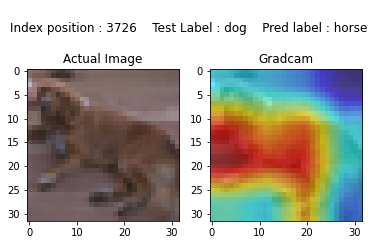

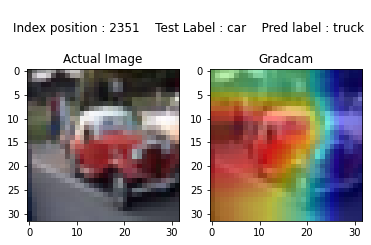

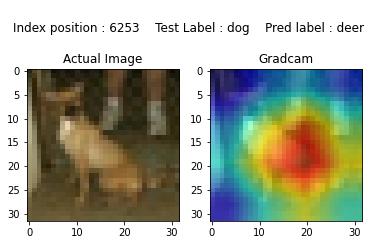

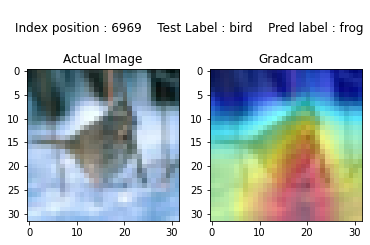

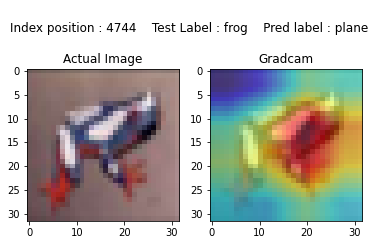

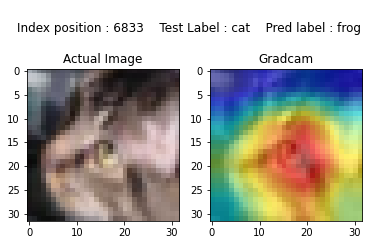

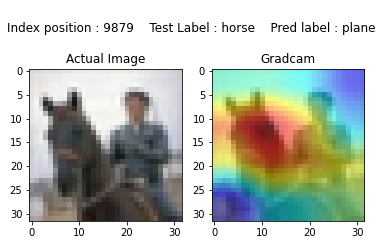

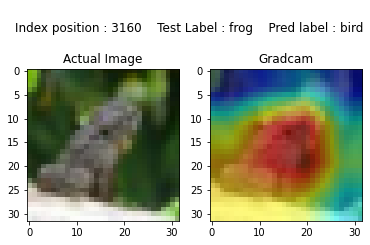

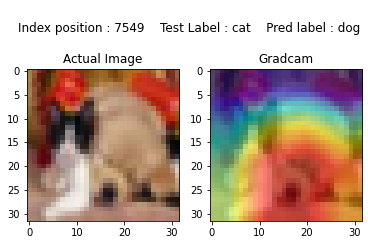

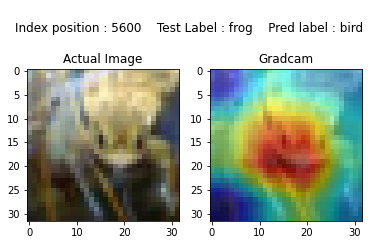

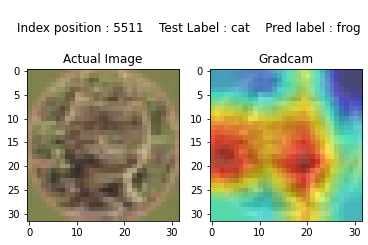

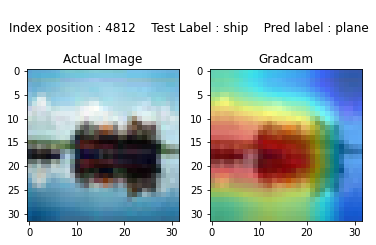

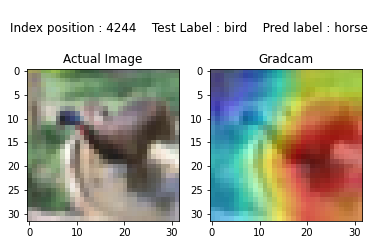

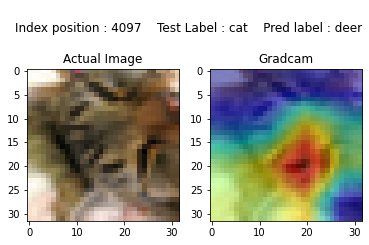

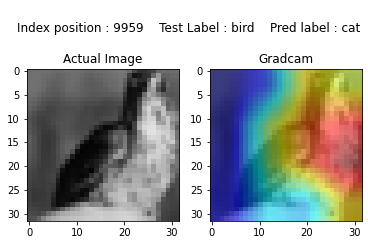

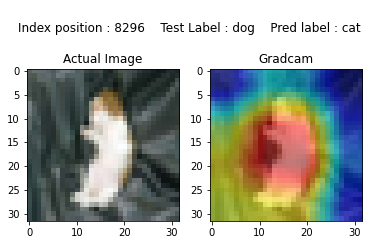

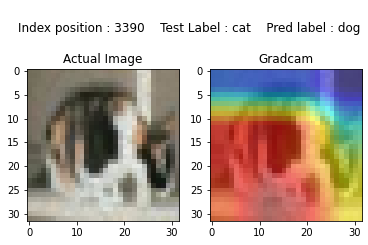

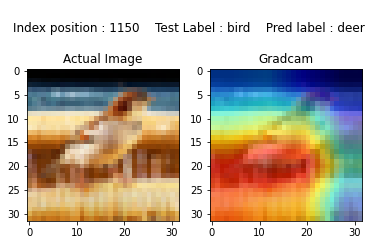

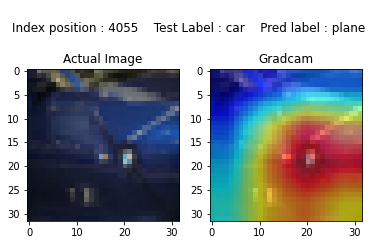

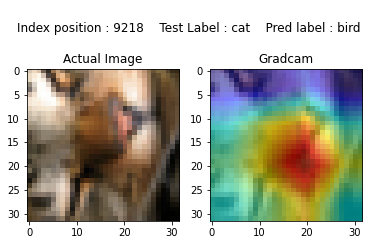

In [0]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
pred = predict(model,device,test_loader)
correct,missclassified = get_misclassified(pred,testset.targets)
layer='layer4'
gradcam_plot(layer,model,missclassified,25,testset,classes)

